In [1]:
import numpy as np
from rich.pretty import Pretty
from sigpyproc.readers import FilReader

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
off_Fil = FilReader("/home/jovyan/work/phys641data/Data/blank_sky.fil") # off 
on_Fil = FilReader("/home/jovyan/work/phys641data/Data/calibrator_source.fil") # on

In [4]:
Pretty(on_Fil.header)

Header(
    filename='/home/jovyan/work/phys641data/Data/calibrator_source.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.353596809546,
    nsamples=30518,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (72.26000547, 45.02999878)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='/home/jovyan/work/phys641data/Data/calibrator_source.fil',
                hdrlen=414,
                datalen=125001728,
                nsamples=30518,
                tstart=60638.353596809546,
                tsamp=0.00032768
            )
        ]
    )
)

In [9]:
off_data = off_Fil.read_block(0,off_Fil.header.nsamples,off_Fil.header.fch1,off_Fil.header.nchans)

In [10]:
off_data_array = off_data.data

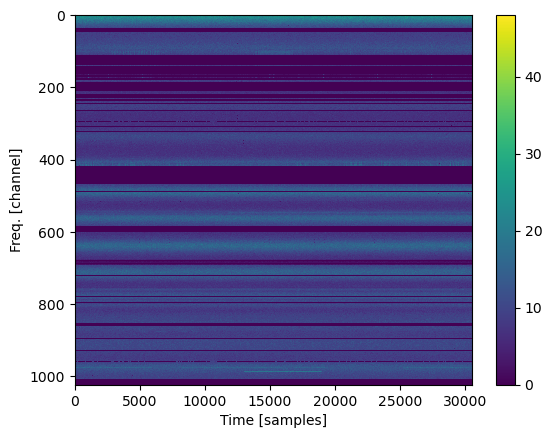

In [11]:
plt.figure()
plt.imshow(off_data_array,aspect='auto',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time [samples]')
plt.ylabel('Freq. [channel]')
plt.show()

# Compute Stats

In [16]:
off_Fil.compute_stats()

Output()

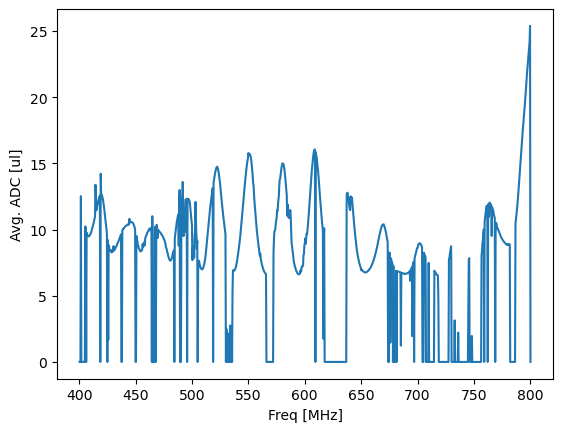

In [23]:
plt.figure()
plt.plot(off_Fil.header.chan_freqs, off_Fil.chan_stats.mean)
plt.ylabel('Avg. ADC [ul]')
plt.xlabel('Freq [MHz]')
plt.show()


In [18]:
norm_off_data_array = (off_data_array - off_Fil.chan_stats.mean[:,None]) / off_Fil.chan_stats.std[:,None] 

/tmp/ipykernel_37896/2855290139.py:1: RuntimeWarning: invalid value encountered in divide
  norm_off_data_array = (off_data_array - off_Fil.chan_stats.mean[:,None]) / off_Fil.chan_stats.std[:,None]


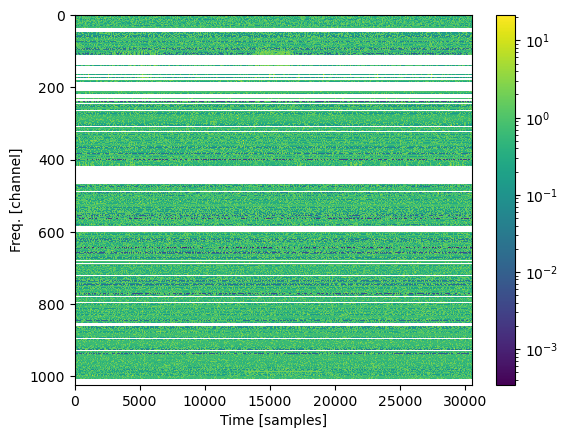

In [68]:
plt.figure()
plt.imshow(np.abs(norm_off_data_array),aspect='auto',interpolation='nearest',norm='log')
plt.colorbar()
plt.xlabel('Time [samples]')
plt.ylabel('Freq. [channel]')
plt.show()


# Flag RFI

In [100]:
_, chan_mask = off_Fil.clean_rfi(method="mad",threshold=3)

Output()

In [101]:
off_Fil_masked = FilReader("/home/jovyan/work/phys641data/Data/blank_sky_masked.fil") # off

In [102]:
off_Fil_masked.compute_stats()

Output()

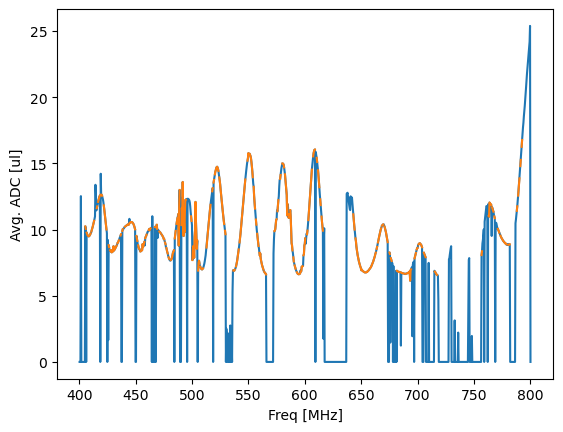

In [103]:
freq_mask = off_Fil_masked.chan_stats.mean == 0
plt.figure()
plt.plot(off_Fil_masked.header.chan_freqs, 
         off_Fil.chan_stats.mean)
plt.plot(off_Fil_masked.header.chan_freqs, 
         np.where(~freq_mask,off_Fil_masked.chan_stats.mean,np.nan))
plt.ylabel('Avg. ADC [ul]')
plt.xlabel('Freq [MHz]')
plt.show()

# Downsample

In [104]:
off_Fil_masked.downsample(tfactor=32)

Output()

'blank_sky_masked_f1_t32.fil'

In [105]:
off_Fil_32 = FilReader("/home/jovyan/work/phys641data/Data/blank_sky_masked_f1_t32.fil") 

In [106]:
off_data_32 = off_Fil_32.read_block(0,off_Fil_32.header.nsamples,off_Fil_32.header.fch1,off_Fil_32.header.nchans)

In [107]:
off_data_32_array = off_data_32.data

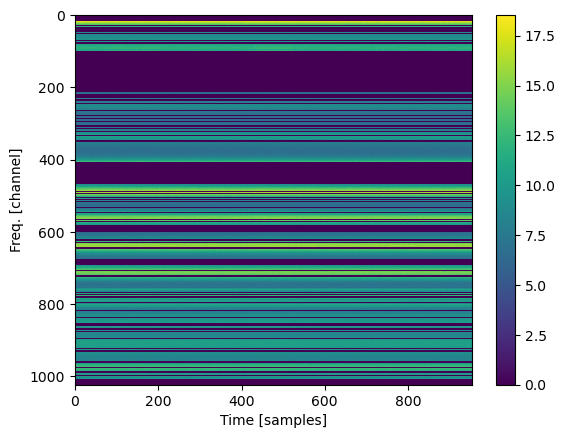

In [108]:
plt.figure()
plt.imshow(off_data_32_array,aspect='auto',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time [samples]')
plt.ylabel('Freq. [channel]')
plt.show()

In [109]:
off_Fil_32.compute_stats()

Output()

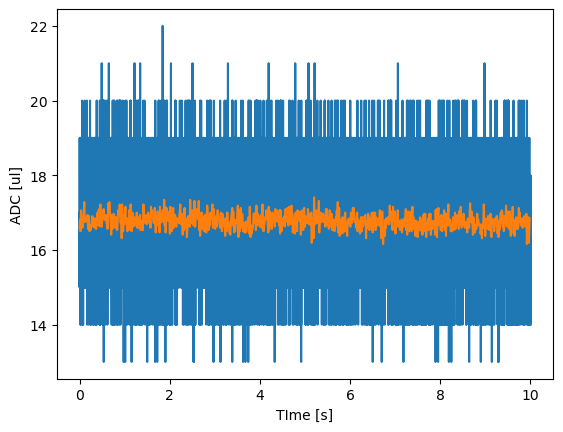

In [110]:
plt.figure()
plt.plot(np.arange(off_Fil.header.nsamples)*off_Fil.header.tsamp,off_data_array[~freq_mask,:][1,:])
plt.plot(np.arange(off_Fil_32.header.nsamples)*off_Fil_32.header.tsamp,off_data_32_array[~freq_mask,:][1,:])
plt.ylabel('ADC [ul]')
plt.xlabel('TIme [s]')
plt.show()




# Dedisperse

In [43]:
off_data_32_d2 = off_data_32.dedisperse(2)

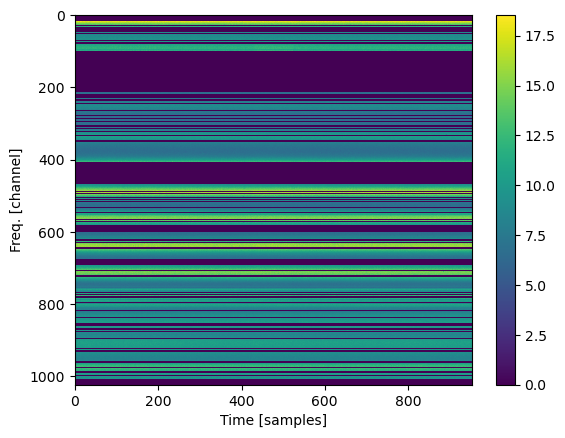

In [45]:
plt.figure()
plt.imshow(off_data_32_d2.data,aspect='auto',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time [samples]')
plt.ylabel('Freq. [channel]')
plt.show()

In [64]:
off_data_32_dmt = off_data_32.dmt_transform(10,dmsteps=11)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]


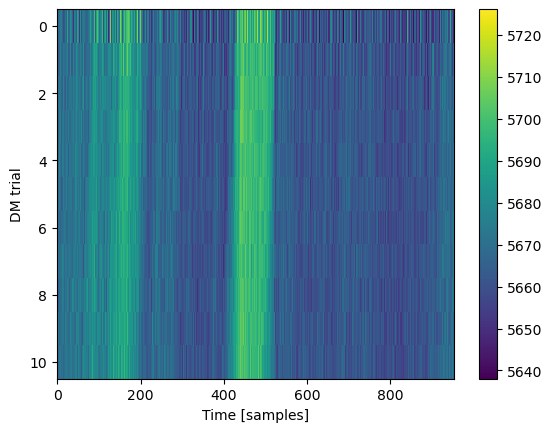

In [65]:
print(off_data_32_dmt.dms)
plt.figure()
plt.imshow(off_data_32_dmt.data[:,:],aspect='auto',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time [samples]')
plt.ylabel('DM trial')
plt.show()

# Fold

In [113]:
off_data_32_folded = off_Fil_32.fold(0.5,2,nints=1,nbands=1024,nbins=int(0.5//off_Fil_32.header.tsamp))

Output()

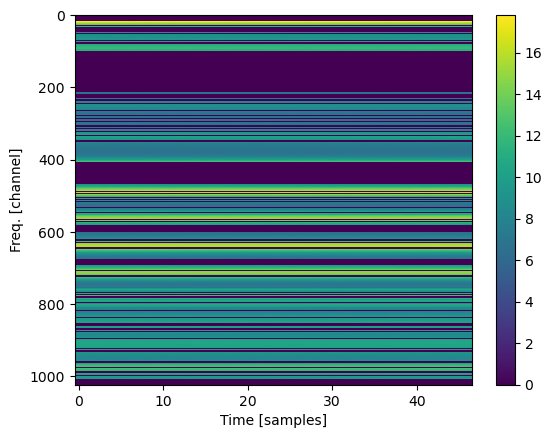

In [114]:
plt.figure()
plt.imshow(off_data_32_folded.data[0,:,:],aspect='auto',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time [samples]')
plt.ylabel('Freq. [channel]')
plt.show()



# Power Spec

In [115]:
off_data_32_d2 = off_data_32.dedisperse(2)

In [116]:
off_data_ts = off_data_32_d2.get_tim()

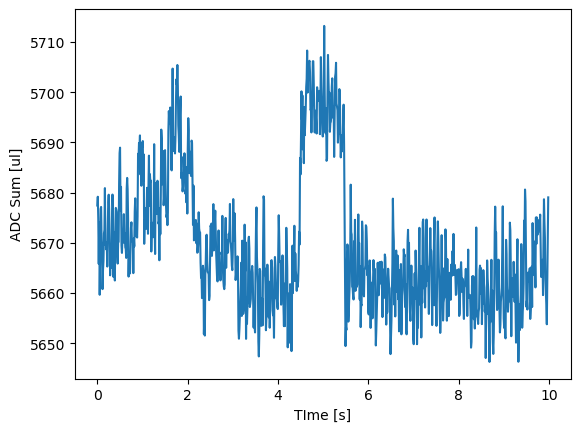

In [122]:
plt.figure()
plt.plot(np.arange(off_Fil_32.header.nsamples)*off_Fil_32.header.tsamp,
         off_data_ts.data)
plt.ylabel('ADC Sum [ul]')
plt.xlabel('TIme [s]')
plt.show()


In [123]:
off_data_spec = off_data_ts.rfft()

In [124]:
off_data_pspec = off_data_spec.form_spec()

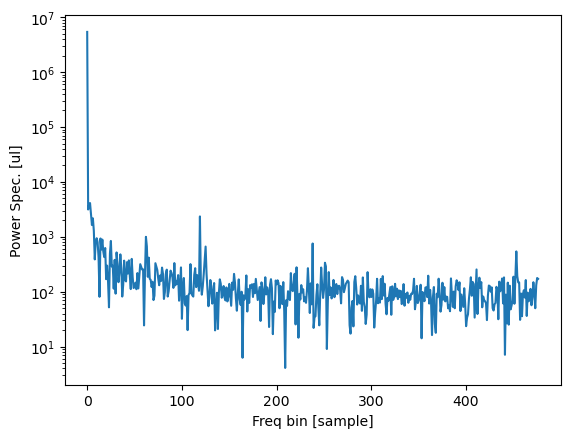

In [129]:
plt.figure()
plt.plot(off_data_pspec.data)
plt.yscale('log')
plt.ylabel('Power Spec. [ul]')
plt.xlabel('Freq bin [sample]')
plt.show()
